In [58]:
import numpy as np
import math

# Computer Experiments with Accelerated by Coupling Directional Search (ACDS) Method. Different norms

<i>Alexander Gasnikov</i> 
<br/>
<i>Moscow Institute of Physics and Technology  (Moscow, Russia)</i>
<br/>
<i>Eduard Gorbunov</i> 
<br/>
<i>Moscow Institute of Physics and Technology (Moscow, Russia)</i>
<br/>
<i>Evgeniya Vorontsova</i> 
<br/>
<i>Far Eastern Federal University (Vladivostok, Russia)</i>

Article: https://arxiv.org/abs/1710.00162v1 (in Russian)

Let $A$ be a real random matrix $n \times n$ with elements from $[0, \, 1]$. 
$$
B = \frac{A^T A}{\lambda_{max}(A^T A)}, \quad x^* = (1, \, 0, \, 0, \, \ldots, \, 0). 
$$

Function to be minimized: $f = \frac{1}{2} \langle x - x^*, \, B(x - x^*) \rangle \, \rightarrow \, \min\limits_x$.


In [59]:
# Power iteration algorithm (eigenvalue algorithm)
def power_iteration(A, maxiter):
    
    b_k = np.random.rand(A.shape[0])
    
    for k in range(0, maxiter):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

In [60]:
n = 10; # Dimension of vector space
x_star = np.zeros(n).reshape(n, 1);
x_star[0] = 1;

A = np.random.rand(n, n);
B = (A.T).dot(A);

# Find B eigenvector associated with the dominant eigenvalue
e_vect = power_iteration(B, 1000)

e_vect_tr = e_vect.reshape(1, e_vect.size)

# Rayleigh quotient
# Dominant eigenvalue of B
e_value = np.dot(e_vect_tr, np.dot(B, e_vect)) / np.dot(e_vect_tr, e_vect)

B = B / e_value
#B = np.eye(n, n)
print(e_value)
#print(B.dot(e_vect))
#print(e_value*e_vect)
#[w, v] = np.linalg.eig(B)
#print(w)
#print(v)

[ 29.37622453]


In [61]:
f = lambda x: 1 / 2 * np.dot((x - x_star).reshape(1, n), np.dot(B, x - x_star))

In [62]:
#Initial point
x0 = np.zeros(n).reshape(n, 1);
x0[n-1] = 1;

L = 1

y0 = x0
z0 = x0

f_star = f(x_star)
f_x = f(x0)

In [63]:
# Generating uniformly distributed numbers on a sphere
def get_rand_vec(dims):
    e = np.random.standard_normal(dims)
    return e / np.linalg.norm(e)

In [64]:
# Dikhotomy method for one-dimensional minimization 
def dihot(func, xa, xb, eps, maxit, a, c):
    
    fa = func(xa, a, c)
    fb = func(xb, a, c)
    if fa*fb > 0:
        print("Error - Dihotomy can't work!")
    
    iter = 0
    while abs(xb-xa) > eps and iter < maxit:  
        xc = (xa+xb) / 2
        fc = func(xc, a, c)
        #print("fc", fc)
        if fa*fc > 0:
            xa = xc
        else:
            xb = xc
            
        iter = iter + 1
    return xc

Распишем отдельно шаг метода для вычисления $z$, используя обозначения из статьи https://arxiv.org/ftp/arxiv/papers/1603/1603.07701.pdf.

Необходимо решить задачу
$$
\tilde{F}(z) = \langle c, \, z \rangle + \frac{1}{2(a-1)} \|z \|_a^2 \, \rightarrow \, \min_z
$$

С помощью метода множителей Лагранжа получаем
$$
\tilde{G}(\lambda) = \min_{t, \, z_k} \left \{ \sum_{k = 1}^n c_k z_k + \frac{1}{2(a-1)} t +  \lambda \left (\sum_{k=1}^n z_k^a - t^{a/2} \right ) \right \}.
$$


Необходимо решить задачу
$$
\max_{\lambda \, \ge \, 0} \tilde{G} (\lambda).
$$

Для этого найдем выражения для $t^*(\lambda)$ и $z_k^*(\lambda)$:
$$
t^* = \left [ \lambda a (a - 1) \right ]^{\frac{2}{2-a}}, \quad z_k^* = \left (-\frac{c_k}{\lambda a} \right )^{\frac{1}{a-1}}
$$

Пусть $\breve{G}(\lambda) = - \tilde{G}(\lambda)$. Тогда задача для решения
$$
\min_{\lambda \, \ge \, 0} \breve{G} (\lambda).
$$
При этом 
$$
\frac{\partial \breve{G}(\lambda)}{\partial \lambda} = t^*(\lambda)^{a/2} - \sum_{k=1}^n \left (z_k^*(\lambda) \right )^a
$$
Получилась задача одномерной минимизации, её можно решить простой дихотомией.

Примечание. В нашем случае $c = \alpha_{k+1} \langle B x^{k+1}, \, e^{k + 1} \rangle e^{k + 1} - \nabla d(z^k)$, $d(z) = \frac{1}{2(a-1)} \| z \|_a^2$, $a = 1 + \frac{1}{2 \ln n}$.


In [65]:
# Prox-function 
# z should be a vector, not a matrix (use np.ravel() to convert)
def d(z, a):
    norm_z = np.linalg.norm(z, a)
    return 1/ 2 / (a - 1) * norm_z* norm_z

In [66]:
#Gradient of prox-function 
def grad_d(z, a):
    g = np.zeros(n).reshape(n, 1)
    norm_z = np.linalg.norm(np.ravel(z), a)
    nzz = 1/ (a - 1)*pow(norm_z, 2 - a)
    for k in range(0, n):
        g[k] = nzz * pow(abs(z[k]), a - 1)
        
    return g

In [67]:
#Gradient G(lambda) 
def grad_G(lam, a, c):
    z = np.zeros(n).reshape(n, 1)
    g = np.zeros(n).reshape(n, 1)
    
    t = pow(lam * a * (a - 1), 2 / (2 - a))
    
    sum_z = 0
    for k in range(0, n):
        z[k] = pow( abs(- c[k] / lam / a), 1 / (a - 1))
        sum_z = sum_z + pow(z[k], a)
        
    g = pow(t, a / 2) - sum_z
    return g

In [68]:
eps = 1e-3

p1 = 1 + 1 / (2 * math.log(n))
q1 = p1 / (p1 - 1)
#q1 = 0

p2 = 1.99
q2 = p2 / (p2 - 1)
#q2 = 2

C_const1 = math.sqrt(3) * min([2*q1 - 1, 32* math.log(n) - 8]) * pow(n, 2/q1 + 1)
C_const2 = math.sqrt(3) * min([2*q2 - 1, 32* math.log(n) - 8]) * pow(n, 2/q2 + 1)
print(C_const1, C_const2)
L = 1
Vx01 = d(np.ravel(x_star), p1) - d(np.ravel(x0), p1) - grad_d(x0, p1).T.dot(x_star - x0)
Vx02 = d(np.ravel(x_star), p2) - d(np.ravel(x0), p2) - grad_d(x0, p2).T.dot(x_star - x0)
print(Vx01, Vx02)

N1 = 2 * math.sqrt(int(Vx01) * L * C_const1 / eps)
N2 = 2 * math.sqrt(int(Vx02) * L * C_const2 / eps)
print("Number of iteration (required):", math.ceil(N1), math.ceil(N2))

402.17426553766074 517.096377631156
[[ 4.60517019]] [[ 1.01010101]]
Number of iteration (required): 2537 1439


In [69]:
import copy

k = 0

x1 = x0[:]
z1 = z0[:]
y1 = y0[:]

x2 = copy.deepcopy(x0)
z2 = copy.deepcopy(z0)
y2 = copy.deepcopy(y0)

f_y1 = f_x
f_y2 = f_x

maxit = 15000

plt1 = []
plt2 = []

while abs(f_y1 - f_star) > eps and k < maxit:
    tau = 2. / (k + 2)
    x1 = tau * z1 + (1 - tau) * y1
    x2 = tau * z2 + (1 - tau) * y2
        
    e = get_rand_vec(n)
        
    bxe1 = np.dot(np.dot(B, x1 - x_star).reshape(1, n), e) * e;
    bxe2 = np.dot(np.dot(B, x2 - x_star).reshape(1, n), e) * e;
        
    y1 = x1 - 1. / L * bxe1.reshape(n, 1);
    y2 = x2 - 1. / L * bxe2.reshape(n, 1);
        
    alpha1 = (k + 2) / 2 / L / C_const1;
    alpha2 = (k + 2) / 2 / L / C_const2;
        
    c1 = alpha1*n*bxe1.reshape(n, 1) - grad_d(z1, p1)
    c2 = alpha2*n*bxe2.reshape(n, 1) - grad_d(z2, p2)
        
    lam1 = dihot(grad_G, eps, 100, eps/10, maxit, p1, c1)
    lam2 = 1
        
    for ii in range(0, n):
        z1[ii] = pow( abs(- c1[ii] / lam1 / p1), 1 / (p1 - 1))
        #z2[ii] = -c2[ii]
        z2[ii] = pow( abs(- c2[ii] / lam2 / p2), 1 / (p2 - 1))
            
    f_y1 = f(y1)
    f_y2 = f(y2)
    plt1.append(abs(f_y1[0][0]))
    plt2.append(abs(f_y2[0][0]))
    
    if k%100 == 0:
        print("f_y1", f_y1, k)
        print("f_y2", f_y2, k)
        
    k = k + 1
print(k, f_y1, f_y2)    

f_y1 [[ 0.04304875]] 0
f_y2 [[ 0.04304875]] 0
f_y1 [[ 0.02762776]] 100
f_y2 [[ 0.01082011]] 100
f_y1 [[ 0.02025926]] 200
f_y2 [[ 0.00848184]] 200
f_y1 [[ 0.01140242]] 300
f_y2 [[ 0.00755614]] 300
f_y1 [[ 0.00496843]] 400
f_y2 [[ 0.00598291]] 400
f_y1 [[ 0.00178213]] 500
f_y2 [[ 0.00494307]] 500
567 [[ 0.00098736]] [[ 0.00474813]]


<IPython.core.display.Javascript object>


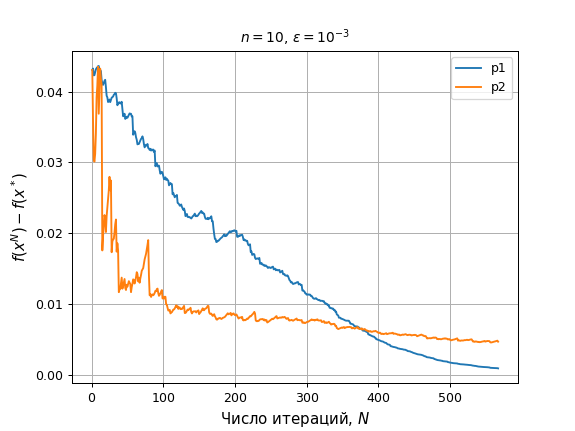

In [72]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, k+1), plt1, label = 'p1')
plt.plot(range(1, k+1), plt2, label = 'p2')
#plt.plot(range(200, k + 1), [4*int(Vx01)*C_const1*L/k/k for k in range(200, k + 1)], label='t')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r"Число итераций, $N$", fontsize=12)
plt.ylabel(r"$f(x^N)- f(x^*) $", fontsize=12)
plt.title(r"$n = 10, \, \varepsilon = 10^{-3}$", fontsize = 11);
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
plt.legend()

<IPython.core.display.Javascript object>


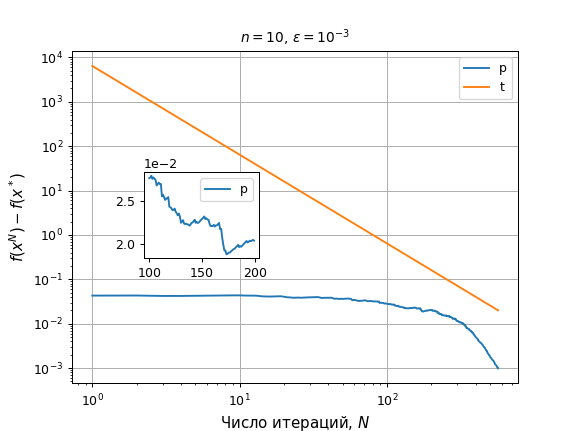

  adjustable: [ 'box' | 'datalim' | 'box-forced'] 
  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  anchor: unknown
  animated: [True | False] 
  aspect: unknown
  autoscale_on: unknown
  autoscalex_on: unknown
  autoscaley_on: unknown
  axes: an :class:`~matplotlib.axes.Axes` instance 
  axes_locator: unknown
  axisbelow: [ *True* | *False* | 'line' ] 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  color_cycle: unknown
  contains: a callable function 
  facecolor: unknown
  fc: unknown
  figure: unknown
  frame_on: [ *True* | *False* ] 
  gid: an id string 
  label: string or anything printable with '%s' conversion. 
  navigate: [ *True* | *False* ] 
  navigate_mode: unknown
  path_effects: unknown
  picker: [None|float|boolean|callable] 
  position: unknown
  rasterization_zorder

In [79]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, k+1), plt1, label = 'p')
plt.plot(range(1, k + 1), [4*int(Vx01)*C_const1*L/k/k for k in range(1, k + 1)], label='t')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"Число итераций, $N$", fontsize=12)
plt.ylabel(r"$f(x^N) - f(x^*) $", fontsize=12)
plt.title(r"$n = 10, \, \varepsilon = 10^{-3}$", fontsize = 11)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
plt.legend()

# Generate data for the zoomed portion
X_detail = range(100, 200)
Y_detail = [plt1[y] for y in X_detail]

 # location for the zoomed portion 
sub_axes = plt.axes([0.25, 0.4, 0.2, 0.2]) 

# plot the zoomed portion
sub_axes.plot(X_detail, Y_detail, label = 'p')#, c = 'k') 
sub_axes.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
sub_axes.legend()

# insert the zoomed figure
plt.setp(sub_axes)

plt.show()